<a href="https://colab.research.google.com/github/AristiPap/Thesis_Stuff/blob/main/BoundaryAttack_1000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
try:
	raw_input
except:
	raw_input = input

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import matplotlib.pyplot as plt
import numpy as np



import numpy as np
import time
import os
from PIL import Image
import sys
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

RESNET_MEAN = np.array([103.939, 116.779, 123.68])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install import-ipynb
import import_ipynb

In [ ]:
%cd "/content/drive/MyDrive/Thesis_notebooks"
import Carlini_Wagner

/content/drive/MyDrive/Thesis_notebooks



![](https://drive.google.com/uc?export=view&id=1YMexys51Bbmkb-JDdFF1AiKWOpot-SEE)


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.config.run_functions_eagerly(True)
model = tf.keras.applications.VGG16()
[(_, height, width, _)] = model.layers[0].input_shape
size = height, width


path = '/content/drive/MyDrive/Thesis_notebooks/my_boundary_attack/boundary-attack-master/images/original/awkward_moment_seal.png' #'/content/drive/MyDrive/Thesis_notebooks/adversarials-master/files/images/sea_lion.jpg'
aa = Carlini_Wagner.AdversarialAttack(attack_algorithm='carlini_wagner', model=model)
input_image = aa.load_and_format_img(path, size)
# target 291 meaning the target class is the lion, see: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
adv_img = aa.perform_attack(input_image, target=291, epochs=100, tb_path='./logs/cw/sea_lion/')
aa.save_img_with_timestamp(adv_img, directory='/content/drive/MyDrive/Thesis_notebooks/adversarials-master/files/images', name='cw_sea_lion_1000_epochs_t_291')

100%|██████████| 100/100 [04:07<00:00,  2.47s/it]


![](https://drive.google.com/uc?export=view&1YMexys51Bbmkb-JDdFF1AiKWOpot-SEE)


In [ ]:
def sphere_perturbation(delta, prev_sample, target_sample):
    """Generate orthogonal perturbation."""
    perturb = np.random.randn(1, 224, 224, 3)
    perturb /= np.linalg.norm(perturb, axis=(1, 2))
    perturb *= delta * np.mean(get_diff(target_sample, prev_sample))
    # Project perturbation onto sphere around target
    # Orthorgonal vector to sphere surface
    diff = (target_sample - prev_sample).astype(np.float32)
    diff /= get_diff(target_sample, prev_sample)  # Orthogonal unit vector
    # We project onto the orthogonal then subtract from perturb
    # to get projection onto sphere surface
    perturb -= (np.vdot(perturb, diff) / np.linalg.norm(diff)**2) * diff
    # Check overflow and underflow
    overflow = (prev_sample + perturb) - 255 + RESNET_MEAN
    perturb -= overflow * (overflow > 0)
    underflow = -RESNET_MEAN
    perturb += underflow * (underflow > 0)
    return perturb

In [ ]:
def forward_perturbation(epsilon, prev_sample, target_sample):
    """Generate forward perturbation."""
    perturb = (target_sample - prev_sample).astype(np.float32)
    perturb /= get_diff(target_sample, prev_sample)
    perturb *= epsilon
    return perturb


def get_converted_prediction(sample, classifier):
    """
    The loss of precision often causes the label of the image to change, particularly
    because we are very close to the boundary of the two classes.
    This function checks for the label of the exported sample
    by simulating the export process.
    """
    #sample = (sample + RESNET_MEAN).astype(np.uint8).astype(np.float32) - RESNET_MEAN
    label = decode_predictions(classifier.predict(sample), top=1)[0][0][1]
    return label


def save_image(sample, classifier, folder):
    """Export image file."""
    label = get_converted_prediction(np.copy(sample), classifier)
    print("Labeling from function",label)
    sample = sample.reshape(224, 224, 3)
    # Reverse preprocessing, see https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py
    mean = [103.939, 116.779, 123.68]
    sample[..., 0] += mean[0]
    sample[..., 1] += mean[1]
    sample[..., 2] += mean[2]
    sample = sample[..., ::-1].astype(np.uint8)
    # Convert array to image and save
    sample = Image.fromarray(sample)
    id_no = time.strftime('%Y%m%d_%H%M%S', datetime.datetime.now().timetuple())
    # Save with predicted label for image (may not be adversarial due to uint8 conversion)
    sample.save(os.path.join("/content/drive/MyDrive/Thesis_notebooks/my_boundary_attack/boundary-attack-master/images", folder,"{}_{}.png".format(id_no, label)))

#preprocessing with keras
def preprocess(sample_path):
    """Load and preprocess image file."""
    img = image.load_img(sample_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

#keep mean error for each iteration
def get_diff(sample_1, sample_2):
    """Channel-wise norm of difference between samples."""
    sample_1 = sample_1.reshape(3, 224, 224)
    sample_2 = sample_2.reshape(3, 224, 224)
    diff = []
    for i, channel in enumerate(sample_1):
      diff.append(np.linalg.norm((channel - sample_2[i]).astype(np.float32)))
    return np.array(diff)
    #return np.linalg.norm(sample_1 - sample_2, axis=(1, 2))

In [ ]:
# classifier = ResNet50(weights='imagenet')
# attack_class = classifier.predict(adv_img.reshape(1, 224, 224, 3))
# print(np.argmax(attack_class))
# temp = get_converted_prediction(np.copy(adv_img), classifier)
# print(temp)

In [ ]:
class boundary_attack():
  def __init__(self,init_sample_path,target_sample_path,dir_path):
    #create ResNet Classifier (prefer resnet for better results)
    self.classifier = ResNet50(weights='imagenet')
    #init paths and folders for the statistics
    self.initial_sample = preprocess(init_sample_path)
    self.target_sample = preprocess(target_sample_path)
    self.folder = time.strftime('[%d%m%Y]_%H%M%s', time.localtime())
    os.mkdir(os.path.join(dir_path, self.folder))
    save_image(np.copy(self.initial_sample), self.classifier, self.folder)
    #classifier initialised with our picture (in this case picture of seal that you can faintly see behind the eel when the attack is executed)
    self.attack_class = np.argmax(self.classifier.predict(self.initial_sample))
    #Our target image is the eel.The point is to create an image that looks almost exactly like the eel but has pertrubations "inspired by the seal", 
    #so that it's misclassified
    self.target_class = np.argmax(self.classifier.predict(self.target_sample))

    self.adversarial_sample = self.initial_sample
    self.n_steps = 0
    self.n_calls = 0
    self.epsilon = 1.
    self.delta = 0.1
    self.errors = []
  def _attack(self):
    # Move first step to the boundary
    # get first adversarial point to begin initiating the attack 
    while True:
        trial_sample = self.target_sample + forward_perturbation(self.epsilon * get_diff(self.adversarial_sample, self.target_sample), self.target_sample, self.adversarial_sample)
        prediction = self.classifier.predict(trial_sample.reshape(1, 224, 224, 3))
        
        self.n_calls += 1
        if np.argmax(prediction) == self.attack_class:
          self.adversarial_sample = trial_sample
          break
        else:
          self.epsilon *= 0.9

    # Iteratively run attack
    while True:
        print("Step #{}...".format(self.n_steps))
        # Orthogonal step
        print("\tDelta step...")
        d_step = 0
        while True:
            d_step += 1
            print("\t#{}".format(d_step))
            trial_samples = []
            for i in np.arange(10):
                trial_sample = self.adversarial_sample + sphere_perturbation(self.delta, self.adversarial_sample, self.target_sample)
                trial_samples.append(trial_sample)
            
            trial_samples = np.asarray(trial_samples).reshape((-1,224,224,3))
            predictions = self.classifier.predict(trial_samples)
            self.n_calls += 10
            predictions = np.argmax(predictions, axis=1)
            d_score = np.mean(predictions == self.attack_class)
            if d_score > 0.0:
                if d_score < 0.3:
                    self.delta *= 0.9
                elif d_score > 0.7:
                    self.delta /= 0.9
                self.adversarial_sample = np.array(trial_samples)[np.where(predictions == self.attack_class)[0][0]]
                break
            else:
                self.delta *= 0.9
        # Forward step
        print("\tEpsilon step...")
        e_step = 0
        while True:
            e_step += 1
            print("\t#{}".format(e_step))
            trial_sample = self.adversarial_sample + forward_perturbation(self.epsilon, self.adversarial_sample, self.target_sample)
            prediction = self.classifier.predict(trial_sample)
            self.n_calls += 1
            #adversarial step
            if np.argmax(prediction) == self.attack_class:
                temp = get_converted_prediction(np.copy(trial_sample), self.classifier)
                print(temp)
                self.adversarial_sample = trial_sample
                self.epsilon /= 0.5
                break
            elif e_step > 500:
                break
            else:
                self.epsilon *= 0.5

        self.n_steps += 1
        # keep some checkpoints so that we save the pictures whilst the attack progresses
        if self.n_steps % 10 == 0 or self.n_steps == 1:
            print("{} steps".format(self.n_steps))
            save_image(np.copy(self.adversarial_sample), self.classifier, self.folder)
        diff = np.mean(get_diff(self.adversarial_sample, self.target_sample))
        self.errors.append(diff)
        #stop at 1000 steps ~= 40 minutes
        if diff <= 1e-3 or e_step > 500: #or self.n_steps > 1000:
            print("{} steps".format(self.n_steps))
            print("Mean Squared Error: {}".format(diff))
            save_image(np.copy(self.adversarial_sample), self.classifier, self.folder)
            break

        print("Mean Squared Error: {}".format(diff))
        print("Calls: {}".format(self.n_calls))
        print("Attack Class: {}".format(self.attack_class))
        print("Target Class: {}".format(self.target_class))
        print("Adversarial Class: {}".format(np.argmax(prediction)))


In [ ]:
import datetime
init_path = '/content/drive/MyDrive/Thesis_notebooks/my_boundary_attack/boundary-attack-master/images/original/awkward_moment_seal.png'
target_path ='/content/drive/MyDrive/Thesis_notebooks/my_boundary_attack/boundary-attack-master/images/original/bad_joke_eel.png'
_dir_path = "/content/drive/MyDrive/Thesis_notebooks/my_boundary_attack/boundary-attack-master/images"
model2 = boundary_attack(init_path,target_path,_dir_path)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Labeling from function sea_lion


In [ ]:
model2._attack()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Streaming output truncated to the last 5000 lines.
Adversarial Class: 150
Step #591...
	Delta step...
	#1
	Epsilon step...
	#1
sea_lion
Mean Squared Error: 5405.080078125
Calls: 7225
Attack Class: 150
Target Class: 390
Adversarial Class: 150
Step #592...
	Delta step...
	#1
	Epsilon step...
	#1
sea_lion
Mean Squared Error: 5408.14599609375
Calls: 7236
Attack Class: 150
Target Class: 390
Adversarial Class: 150
Step #593...
	Delta step...
	#1
	Epsilon step...
	#1
sea_lion
Mean Squared Error: 5410.19921875
Calls: 7247
Attack Class: 150
Target Class: 390
Adversarial Class: 150
Step #594...
	Delta step...
	#1
	Epsilon step...
	#1
sea_lion
Mean Squared Error: 5410.29736328125
Calls: 7258
Attack Class: 150
Target Class: 390
Adversarial Class: 150
Step #595...
	Delta step...
	#1
	Epsilon step...
	#1
	#2
sea_lion
Mean Squared Error: 5410.3662109375
Calls: 7270
Attack Class: 150
Target Class: 390
Adversarial Class: 150
Step #596...
	Delta step...
	#1
	Epsilon step...
	#1
	#2
	#3
	#4
sea_lion
Mean

##PLot mean error per each step of the algorithm

In [ ]:
import matplotlib.pyplot as plt

def plot_error(model):
  x_data = list(range(0, len(model.errors)))
  y_data = model.errors

  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)

  ax.plot(x_data, y_data)
  ax.set_xlabel('steps to complete')
  ax.set_ylabel('mse')

  plt.show()

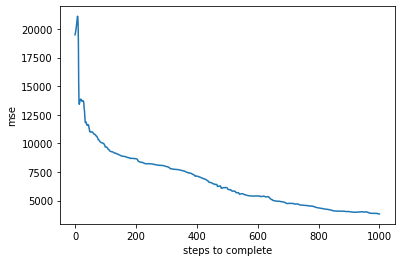

In [ ]:
plot_error(model2)